In [311]:
import numpy as np 
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt

In [312]:
# load image from npy file
images = np.load('tranformed_cavallo.npy')
print(images.shape)

(2623, 120, 120, 3)


In [328]:
def divide_image(image, dim):
    parts = []
    height, width, _ = image.shape
    subpart_width = width // dim
    subpart_height = height // dim
    
    for i in range(dim):
        for j in range(dim):
            part = image[i*subpart_height:(i+1)*subpart_height, j*subpart_width:(j+1)*subpart_width]
            parts.append(part)
    
    return parts

In [329]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        temp = []
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        #further divide each part into 4x4 subpart
        for i in range(len(combination)):
            temp += divide_image(combination[i], 4)

        combinations.append(temp)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [330]:
# parts = divide_image(images[1], 3)
# combinations, original_positions = generate_combinations(parts, 100)

In [333]:
def divide_image(image):
    subparts = []
    height, width, _ = image.shape
    subpart_width = width // 3
    subpart_height = height // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*subpart_height:(i+1)*subpart_height, j*subpart_width:(j+1)*subpart_width]
            for k in range(4):
                for l in range(4):
                    subpart = part[k*subpart_height//4:(k+1)*subpart_height//4, l*subpart_width//4:(l+1)*subpart_width//4]
                    subparts.append(subpart)
    
    return subparts

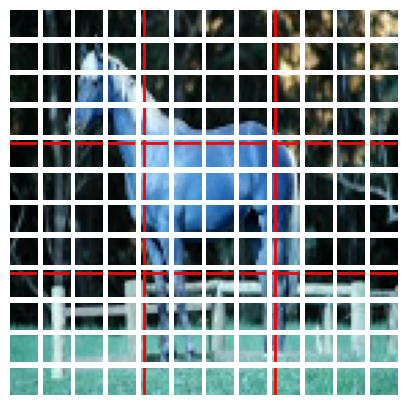

In [334]:
parts = divide_image(images[1])

# plot combinations[0]
ig, axs = plt.subplots(12, 12, figsize=(5, 5))
for i in range(3): 
    for j in range(3):
        # subpart in a part
        for k in range(16):
            start_idx = (i * 3 + j) * 16 + k
            tile = parts[start_idx]
            ax = axs[i*4 + k // 4, j*4 + k % 4]
            ax.imshow(tile)
            ax.axis('off')


# draw line after every 4 parts
for i in range(12):
    axs[4, i].axhline(y=0.5, color='red', linewidth=2)
    axs[8, i].axhline(y=0.5, color='red', linewidth=2)
    axs[i, 4].axvline(x=0.5, color='red', linewidth=2)
    axs[i, 8].axvline(x=0.5, color='red', linewidth=2)

In [335]:
import torch
from torch_geometric.data import Data

In [336]:
def create_graph(subparts):
    # Define the number of nodes and edges
    num_nodes = 144
    internal_edges = []  # List to store internal edges within each 4x4 grid
    part_adjacent_edges = []  # List to store edges between adjacent parts
    
    # Define internal edges between consecutive subparts in each 4x4 grid (tile)
    for part_idx in range(9):  # There are 9 parts in the 3x3 grid
        # Calculate the starting index for the current part
        start_idx = part_idx * 16

        # Connect each node in the 4x4 grid
        for row in range(4):
            for col in range(4):
                current_index = start_idx + row * 4 + col

                # Connect to the right neighbor (if exists)
                if col < 3:
                    right_neighbor_index = current_index + 1
                    internal_edges.append((current_index, right_neighbor_index))
                    internal_edges.append((right_neighbor_index, current_index))

                # Connect to the bottom neighbor (if exists)
                if row < 3:
                    bottom_neighbor_index = current_index + 4
                    internal_edges.append((current_index, bottom_neighbor_index))
                    internal_edges.append((bottom_neighbor_index, current_index))

    # Define edges between adjacent parts (horizontally and vertically)
    # Horizontal connections
    for part_row in range(3):  # 3 rows of parts
        for part_col in range(2):  # 2 columns of adjacent parts
            # Calculate the start index of each adjacent part
            part1_start_idx = (part_row * 3 + part_col) * 16
            part2_start_idx = (part_row * 3 + part_col + 1) * 16
            
            # Connect each node in the rightmost column of part1 with the leftmost column of part2
            for row in range(4):
                part1_node_index = part1_start_idx + row * 4 + 3  # Rightmost column in part1
                part2_node_index = part2_start_idx + row * 4  # Leftmost column in part2
                
                part_adjacent_edges.append((part1_node_index, part2_node_index))
                part_adjacent_edges.append((part2_node_index, part1_node_index))

    # Vertical connections
    for part_col in range(3):  # 3 columns of parts
        for part_row in range(2):  # 2 rows of adjacent parts
            # Calculate the start index of each adjacent part
            part1_start_idx = (part_row * 3 + part_col) * 16
            part2_start_idx = ((part_row + 1) * 3 + part_col) * 16
            
            # Connect each node in the bottommost row of part1 with the topmost row of part2
            for col in range(4):
                part1_node_index = part1_start_idx + (3 * 4) + col  # Bottommost row in part1
                part2_node_index = part2_start_idx + col  # Topmost row in part2
                
                part_adjacent_edges.append((part1_node_index, part2_node_index))
                part_adjacent_edges.append((part2_node_index, part1_node_index))

    # Combine internal edges and part adjacent edges into one edge list
    # Create an attribute list to label each edge type
    edges = internal_edges + part_adjacent_edges
    edge_type = [0] * len(internal_edges) + [1] * len(part_adjacent_edges)  # 0 for internal, 1 for adjacent
    
    # Convert edges list to a tensor and transpose it
    edge_index = torch.tensor(edges).T
    edge_attr = torch.tensor(edge_type)  # Attribute tensor for edge types

    # Convert subparts list to a tensor of shape `(num_nodes, C, H, W)`
    # Assuming each subpart is a tensor with shape (C, H, W)
    subparts = [torch.tensor(subpart).view(-1) for subpart in subparts]
    node_features = torch.stack(subparts)  # Stack list of tensors into one tensor

    # Create the Data object for PyTorch Geometric
    graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

    return graph_data

In [337]:
graph_data = create_graph(parts)
graph_data

Data(x=[144, 300], edge_index=[2, 528], edge_attr=[528])

In [338]:
def print_edge_list(graph_data):
    # Access the edge_index tensor from the graph_data object
    edge_index = graph_data.edge_index

    # Convert the tensor to a list of edges
    edge_list = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))

    # Print the edge list
    for edge in edge_list:
        print(edge)

# Assuming graph_data is the Data object created earlier
print_edge_list(graph_data)

(0, 1)
(1, 0)
(0, 4)
(4, 0)
(1, 2)
(2, 1)
(1, 5)
(5, 1)
(2, 3)
(3, 2)
(2, 6)
(6, 2)
(3, 7)
(7, 3)
(4, 5)
(5, 4)
(4, 8)
(8, 4)
(5, 6)
(6, 5)
(5, 9)
(9, 5)
(6, 7)
(7, 6)
(6, 10)
(10, 6)
(7, 11)
(11, 7)
(8, 9)
(9, 8)
(8, 12)
(12, 8)
(9, 10)
(10, 9)
(9, 13)
(13, 9)
(10, 11)
(11, 10)
(10, 14)
(14, 10)
(11, 15)
(15, 11)
(12, 13)
(13, 12)
(13, 14)
(14, 13)
(14, 15)
(15, 14)
(16, 17)
(17, 16)
(16, 20)
(20, 16)
(17, 18)
(18, 17)
(17, 21)
(21, 17)
(18, 19)
(19, 18)
(18, 22)
(22, 18)
(19, 23)
(23, 19)
(20, 21)
(21, 20)
(20, 24)
(24, 20)
(21, 22)
(22, 21)
(21, 25)
(25, 21)
(22, 23)
(23, 22)
(22, 26)
(26, 22)
(23, 27)
(27, 23)
(24, 25)
(25, 24)
(24, 28)
(28, 24)
(25, 26)
(26, 25)
(25, 29)
(29, 25)
(26, 27)
(27, 26)
(26, 30)
(30, 26)
(27, 31)
(31, 27)
(28, 29)
(29, 28)
(29, 30)
(30, 29)
(30, 31)
(31, 30)
(32, 33)
(33, 32)
(32, 36)
(36, 32)
(33, 34)
(34, 33)
(33, 37)
(37, 33)
(34, 35)
(35, 34)
(34, 38)
(38, 34)
(35, 39)
(39, 35)
(36, 37)
(37, 36)
(36, 40)
(40, 36)
(37, 38)
(38, 37)
(37, 41)
(41, 37)


In [339]:
import networkx as nx

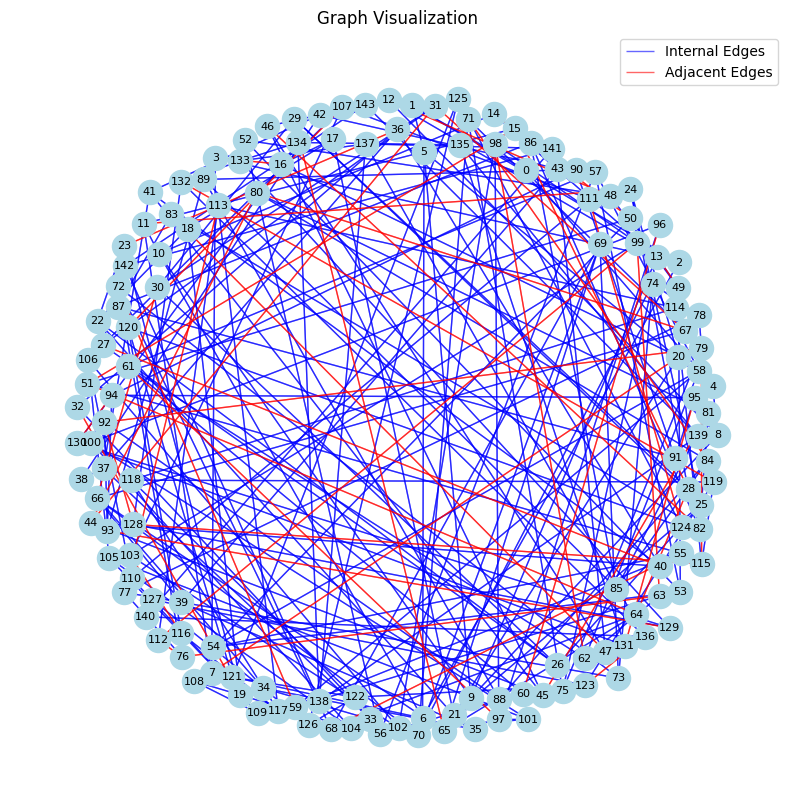

In [340]:
def visualize_graph(graph_data):
    # Convert the torch_geometric.data.Data object to a NetworkX graph
    G = nx.Graph()
    # Add nodes with their features
    G.add_nodes_from(range(graph_data.num_nodes))

    # Retrieve edge_index and edge_attr from the graph data
    edge_index = graph_data.edge_index
    edge_attr = graph_data.edge_attr
    
    # Initialize lists to store edges of different types
    internal_edges = []
    adjacent_edges = []
    
    # Separate edges based on edge type
    for i in range(edge_index.shape[1]):
        source = edge_index[0][i].item()
        target = edge_index[1][i].item()
        edge_type = edge_attr[i].item()  # Retrieve edge type
        
        # Categorize edges by type
        if edge_type == 0:
            internal_edges.append((source, target))
        elif edge_type == 1:
            adjacent_edges.append((source, target))
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)  # Compute graph layout

    # Draw nodes with their features
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')

    # Draw internal edges (within 4x4 grids) in one color
    nx.draw_networkx_edges(G, pos, edgelist=internal_edges, edge_color='blue', alpha=0.6, label='Internal Edges')

    # Draw adjacent edges (between 3x3 parts) in another color
    nx.draw_networkx_edges(G, pos, edgelist=adjacent_edges, edge_color='red', alpha=0.6, label='Adjacent Edges')

    # Add labels to nodes (if you have node features, you can add them as labels)
    node_labels = {i: str(i) for i in range(graph_data.num_nodes)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    # Add a legend for edge colors
    plt.legend()

    # Show the plot
    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

# Assuming graph_data is the Data object created earlier
visualize_graph(graph_data)

In [341]:
def create_bipartite_graph(graph_data):
    # Create a bipartite graph
    B = nx.Graph()
    
    # Define the part nodes and subpart nodes
    num_parts = 9  # 3x3 grid of parts
    num_subparts = 144  # Total number of subparts

    # Add nodes to the bipartite graph
    # Part nodes are represented by integers from 0 to 8 (9 parts)
    # Subpart nodes are represented by integers from 9 to 152 (144 subparts)
    B.add_nodes_from(range(num_parts), bipartite=0)  # Part nodes
    B.add_nodes_from(range(num_parts, num_parts + num_subparts), bipartite=1)  # Subpart nodes

    # Define edges between parts and subparts
    # For each part, add edges to the subparts that belong to that part
    for part_idx in range(num_parts):
        start_idx = part_idx * 16
        for i in range(16):
            subpart_idx = start_idx + i
            B.add_edge(part_idx, num_parts + subpart_idx)  # Connect part to subpart

    # Add edges from graph_data
    # These are the connections within subparts and across parts
    edge_index = graph_data.edge_index
    edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))

    # Adjust the indices of subpart nodes by adding num_parts
    adjusted_edges = [(u + num_parts, v + num_parts) for u, v in edges]
    B.add_edges_from(adjusted_edges)

    return B

def visualize_bipartite_graph(B):
    # Draw the bipartite graph
    plt.figure(figsize=(12, 12))
    
    # Use NetworkX's bipartite layout for better visualization
    pos = nx.bipartite_layout(B, nodes=[n for n in B.nodes() if B.nodes[n]['bipartite'] == 0], scale=2)  # Use a scale factor to increase spacing
    
    # Draw nodes with different shapes and colors
    part_nodes = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
    subpart_nodes = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 1]
    
    # Customize node size and color
    nx.draw_networkx_nodes(B, pos, nodelist=part_nodes, node_color='lightblue', node_size=500, node_shape='s', alpha=0.7)
    nx.draw_networkx_nodes(B, pos, nodelist=subpart_nodes, node_color='lightgreen', node_size=200, node_shape='o', alpha=0.7)
    
    # Draw edges with reduced alpha (transparency) for less clutter
    nx.draw_networkx_edges(B, pos, edge_color='gray', alpha=0.4, width=1)
    
    # Add labels to nodes
    labels = {n: str(n) for n in B.nodes()}
    nx.draw_networkx_labels(B, pos, labels=labels, font_size=4)
    
    # Display the plot
    plt.title('Bipartite Graph: Parts and Subparts')
    plt.axis('off')
    plt.show()


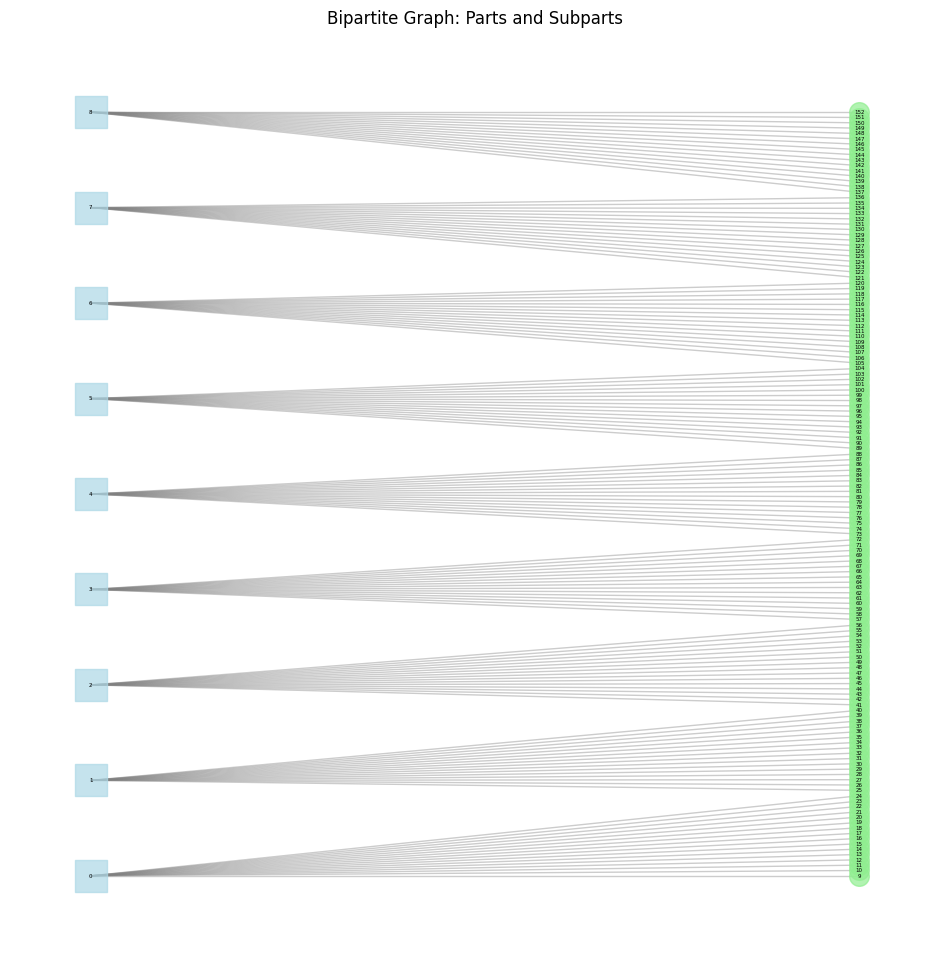

In [342]:
B = create_bipartite_graph(graph_data)
visualize_bipartite_graph(B)

In [343]:
first_part_nodes = list(range(16))

# Access the edge_index and edge_attr tensors from the graph_data object
edge_index = graph_data.edge_index
edge_attr = graph_data.edge_attr

# Filter edges where the source node (first row of edge_index) is in the first part
edges_from_first_part = []

# Iterate through all edges in edge_index
for i in range(edge_index.shape[1]):
    source_node = edge_index[0][i].item()
    target_node = edge_index[1][i].item()
    
    # Check if the source node is in the first part
    if source_node in first_part_nodes:
        # Retrieve the edge attribute for this edge
        edge_attribute = edge_attr[i].item()
        # Append the edge and its attribute to the list
        edges_from_first_part.append((source_node, target_node, edge_attribute))

# Print the edges connected from the first part along with their attributes
print("Edges connected from the first part (nodes 0 to 15) with their attributes:")
for edge in edges_from_first_part:
    print(f"{edge[0]} to {edge[1]} --> {edge[2]}")

Edges connected from the first part (nodes 0 to 15) with their attributes:
0 to 1 --> 0
1 to 0 --> 0
0 to 4 --> 0
4 to 0 --> 0
1 to 2 --> 0
2 to 1 --> 0
1 to 5 --> 0
5 to 1 --> 0
2 to 3 --> 0
3 to 2 --> 0
2 to 6 --> 0
6 to 2 --> 0
3 to 7 --> 0
7 to 3 --> 0
4 to 5 --> 0
5 to 4 --> 0
4 to 8 --> 0
8 to 4 --> 0
5 to 6 --> 0
6 to 5 --> 0
5 to 9 --> 0
9 to 5 --> 0
6 to 7 --> 0
7 to 6 --> 0
6 to 10 --> 0
10 to 6 --> 0
7 to 11 --> 0
11 to 7 --> 0
8 to 9 --> 0
9 to 8 --> 0
8 to 12 --> 0
12 to 8 --> 0
9 to 10 --> 0
10 to 9 --> 0
9 to 13 --> 0
13 to 9 --> 0
10 to 11 --> 0
11 to 10 --> 0
10 to 14 --> 0
14 to 10 --> 0
11 to 15 --> 0
15 to 11 --> 0
12 to 13 --> 0
13 to 12 --> 0
13 to 14 --> 0
14 to 13 --> 0
14 to 15 --> 0
15 to 14 --> 0
3 to 16 --> 1
7 to 20 --> 1
11 to 24 --> 1
15 to 28 --> 1
12 to 48 --> 1
13 to 49 --> 1
14 to 50 --> 1
15 to 51 --> 1


In [344]:
def create_data(imgs):
    for i in imgs:
        parts = divide_image(i, 3)
        combinations, _ = generate_combinations(parts, 1)
        for comb in combinations:
            graph_data = create_graph(comb)
            yield graph_data

In [345]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [346]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [347]:
@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [348]:
def filter_adjacent_edges(graph_data):
    # Access edge_index and edge_attr tensors
    edge_index = graph_data.edge_index
    edge_attr = graph_data.edge_attr

    # Lists to store the indices of edges with attribute `1`
    adjacent_edge_indices = []

    # Iterate through each edge
    for i in range(edge_index.shape[1]):
        # Check the edge attribute
        if edge_attr[i].item() == 1:
            adjacent_edge_indices.append(i)

    # Filter edge_index and edge_attr tensors to include only edges with attribute `1`
    filtered_edge_index = edge_index[:, adjacent_edge_indices]
    filtered_edge_attr = edge_attr[adjacent_edge_indices]

    # all idx other tham filtered_edge_index
    all_idx = list(range(edge_index.shape[1]))
    for idx in adjacent_edge_indices:
        all_idx.remove(idx)

    graph_data_edge_index = edge_index[:, all_idx]
    graph_data_edge_attr = edge_attr[all_idx]

    graph_data = Data(
        x=graph_data.x,
        edge_index=graph_data_edge_index,
        edge_attr= graph_data_edge_attr,
    )

    graph_data_adjacent = Data(
        x=graph_data.x,
        edge_index=filtered_edge_index,
        edge_attr=filtered_edge_attr
    )
    
    return graph_data, graph_data_adjacent

In [349]:
graph_data, graph_data_adjacent = filter_adjacent_edges(graph_data)

In [350]:
import torch_geometric.transforms as T

split = T.RandomLinkSplit(
    num_val=0.33,
    num_test=0.33,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,
)

train_data_adjacent, val_data_adjacent, test_data_adjacent = split(graph_data_adjacent)
print("Train data:", train_data_adjacent)
print("Validation data:", val_data_adjacent)
print("Test data:", test_data_adjacent)

Train data: Data(x=[144, 300], edge_index=[2, 36], edge_attr=[36], edge_label=[36], edge_label_index=[2, 36])
Validation data: Data(x=[144, 300], edge_index=[2, 36], edge_attr=[36], edge_label=[30], edge_label_index=[2, 30])
Test data: Data(x=[144, 300], edge_index=[2, 66], edge_attr=[66], edge_label=[30], edge_label_index=[2, 30])


In [ ]:
train_edge_index = train_data_adjacent.edge_index

# Convert edge_index tensor to a list of edges for easier printing
train_edges = list(zip(train_edge_index[0].tolist(), train_edge_index[1].tolist()))

# Print the training data edges
print("Training Data Edges:")
for edge in train_edges:
    print(f"{edge[0]} --> {edge[1]}")

Training Data Edges:
27 --> 40
63 --> 99
119 --> 132
60 --> 96
77 --> 113
63 --> 76
7 --> 20
12 --> 48
95 --> 131
107 --> 120
75 --> 88
11 --> 24
30 --> 66
62 --> 98
23 --> 36
76 --> 112
31 --> 44
14 --> 50
40 --> 27
99 --> 63
132 --> 119
96 --> 60
113 --> 77
76 --> 63
20 --> 7
48 --> 12
131 --> 95
120 --> 107
88 --> 75
24 --> 11
66 --> 30
98 --> 62
36 --> 23
112 --> 76
44 --> 31
50 --> 14


In [ ]:
first_part_nodes = list(range(16))

# Access the edge_index and edge_attr tensors from the graph_data object
edge_index = graph_data.edge_index
edge_attr = graph_data.edge_attr

# Filter edges where the source node (first row of edge_index) is in the first part
edges_from_first_part = []

# Iterate through all edges in edge_index
for i in range(edge_index.shape[1]):
    source_node = edge_index[0][i].item()
    target_node = edge_index[1][i].item()
    
    # Check if the source node is in the first part
    if source_node in first_part_nodes:
        # Retrieve the edge attribute for this edge
        edge_attribute = edge_attr[i].item()
        # Append the edge and its attribute to the list
        edges_from_first_part.append((source_node, target_node, edge_attribute))

# Print the edges connected from the first part along with their attributes
print("Edges connected from the first part (nodes 0 to 15) with their attributes:")
for edge in edges_from_first_part:
    print(f"{edge[0]} to {edge[1]} --> {edge[2]}")

Edges connected from the first part (nodes 0 to 15) with their attributes:
0 to 1 --> 0
1 to 0 --> 0
0 to 4 --> 0
4 to 0 --> 0
1 to 2 --> 0
2 to 1 --> 0
1 to 5 --> 0
5 to 1 --> 0
2 to 3 --> 0
3 to 2 --> 0
2 to 6 --> 0
6 to 2 --> 0
3 to 7 --> 0
7 to 3 --> 0
4 to 5 --> 0
5 to 4 --> 0
4 to 8 --> 0
8 to 4 --> 0
5 to 6 --> 0
6 to 5 --> 0
5 to 9 --> 0
9 to 5 --> 0
6 to 7 --> 0
7 to 6 --> 0
6 to 10 --> 0
10 to 6 --> 0
7 to 11 --> 0
11 to 7 --> 0
8 to 9 --> 0
9 to 8 --> 0
8 to 12 --> 0
12 to 8 --> 0
9 to 10 --> 0
10 to 9 --> 0
9 to 13 --> 0
13 to 9 --> 0
10 to 11 --> 0
11 to 10 --> 0
10 to 14 --> 0
14 to 10 --> 0
11 to 15 --> 0
15 to 11 --> 0
12 to 13 --> 0
13 to 12 --> 0
13 to 14 --> 0
14 to 13 --> 0
14 to 15 --> 0
15 to 14 --> 0


In [ ]:
def combine_edges(graph_data, split_data):
    """
    Combines internal edges from `graph_data` with the edges from `split_data`.
    """
    # Get internal edges from the original graph data
    internal_edge_index = graph_data.edge_index
    internal_edge_attr = graph_data.edge_attr

    # Get edges and attributes from the split data (train/val/test)
    split_edge_index = split_data.edge_index
    split_edge_attr = split_data.edge_attr

    # Combine edge indices and attributes
    combined_edge_index = torch.cat((internal_edge_index, split_edge_index), dim=1)
    combined_edge_attr = torch.cat((internal_edge_attr, split_edge_attr))

    # Create a new Data object with the combined edges
    combined_data = Data(
        x=graph_data.x,  # Use the same node features
        edge_index=combined_edge_index,
        edge_attr=combined_edge_attr
    )

    return combined_data

In [ ]:
# Combine internal edges with training data adjacent edges
train_data_combined = combine_edges(graph_data, train_data_adjacent)

# Combine internal edges with validation data adjacent edges
val_data_combined = combine_edges(graph_data, val_data_adjacent)

# Combine internal edges with testing data adjacent edges
test_data_combined = combine_edges(graph_data, test_data_adjacent)

In [ ]:
first_part_nodes = list(range(16))

# Access the edge_index and edge_attr tensors from the graph_data object
edge_index = train_data_combined.edge_index
edge_attr = train_data_combined.edge_attr

# Filter edges where the source node (first row of edge_index) is in the first part
edges_from_first_part = []

# Iterate through all edges in edge_index
for i in range(edge_index.shape[1]):
    source_node = edge_index[0][i].item()
    target_node = edge_index[1][i].item()
    
    # Check if the source node is in the first part
    if source_node in first_part_nodes:
        # Retrieve the edge attribute for this edge
        edge_attribute = edge_attr[i].item()
        # Append the edge and its attribute to the list
        edges_from_first_part.append((source_node, target_node, edge_attribute))

# Print the edges connected from the first part along with their attributes
print("Edges connected from the first part (nodes 0 to 15) with their attributes:")
for edge in edges_from_first_part:
    print(f"{edge[0]} to {edge[1]} --> {edge[2]}")

Edges connected from the first part (nodes 0 to 15) with their attributes:
0 to 1 --> 0
1 to 0 --> 0
0 to 4 --> 0
4 to 0 --> 0
1 to 2 --> 0
2 to 1 --> 0
1 to 5 --> 0
5 to 1 --> 0
2 to 3 --> 0
3 to 2 --> 0
2 to 6 --> 0
6 to 2 --> 0
3 to 7 --> 0
7 to 3 --> 0
4 to 5 --> 0
5 to 4 --> 0
4 to 8 --> 0
8 to 4 --> 0
5 to 6 --> 0
6 to 5 --> 0
5 to 9 --> 0
9 to 5 --> 0
6 to 7 --> 0
7 to 6 --> 0
6 to 10 --> 0
10 to 6 --> 0
7 to 11 --> 0
11 to 7 --> 0
8 to 9 --> 0
9 to 8 --> 0
8 to 12 --> 0
12 to 8 --> 0
9 to 10 --> 0
10 to 9 --> 0
9 to 13 --> 0
13 to 9 --> 0
10 to 11 --> 0
11 to 10 --> 0
10 to 14 --> 0
14 to 10 --> 0
11 to 15 --> 0
15 to 11 --> 0
12 to 13 --> 0
13 to 12 --> 0
13 to 14 --> 0
14 to 13 --> 0
14 to 15 --> 0
15 to 14 --> 0
7 to 20 --> 1
12 to 48 --> 1
11 to 24 --> 1
14 to 50 --> 1


In [ ]:
def train_link_predictor(
    model, train_loader, val_loader, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0

        # Iterate through the DataLoader
        for batch in train_loader:
            # Zero out the gradients
            optimizer.zero_grad()

            # Encode the batch's node features and edge indices
            z = model.encode(batch.x, batch.edge_index)

            # Sample negative edges
            neg_edge_index = negative_sampling(
                edge_index=batch.edge_index, num_nodes=batch.num_nodes,
                num_neg_samples=batch.edge_label_index.size(1),
                method='sparse'
            )

            # Combine positive and negative edge indices and labels
            edge_label_index = torch.cat(
                [batch.edge_label_index, neg_edge_index],
                dim=-1,
            )
            edge_label = torch.cat([
                batch.edge_label,
                batch.edge_label.new_zeros(neg_edge_index.size(1))
            ], dim=0)

            # Decode and compute the loss
            out = model.decode(z, edge_label_index).view(-1)
            loss = criterion(out, edge_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Compute the average training loss for the epoch
        avg_train_loss = total_loss / len(train_loader)

        # Evaluate the model on validation data
        val_auc = eval_link_predictor(model, val_loader)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Avg Train Loss: {avg_train_loss:.3f}, Val AUC: {val_auc:.3f}")

    return model


In [324]:
import torch_geometric.transforms as T

train_data = []
val_data = []
test_data = []

for i in range(images.shape[0]):

    parts = divide_image(images[i][:,:,0])

    graph_data = create_graph(parts)

    graph_data, graph_data_adjacent = filter_adjacent_edges(graph_data)

    split = T.RandomLinkSplit(
        num_val=0.33,
        num_test=0.33,
        is_undirected=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=1.0,
    )

    train_data_adjacent, val_data_adjacent, test_data_adjacent = split(graph_data_adjacent)

    # Combine internal edges with training data adjacent edges
    train_data_combined = combine_edges(graph_data, train_data_adjacent)
    train_data.append(train_data_combined)

    # Combine internal edges with validation data adjacent edges
    val_data_combined = combine_edges(graph_data, val_data_adjacent)
    val_data.append(val_data_combined)
    # Combine internal edges with testing data adjacent edges
    test_data_combined = combine_edges(graph_data, test_data_adjacent)
    test_data.append(test_data_combined)

In [325]:
train_data[0].x.shape

torch.Size([144, 100])

In [326]:
from torch_geometric.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32)

/opt/homebrew/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [327]:
model = Net(144, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_dataloader, val_dataloader, optimizer, criterion)
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

RuntimeError: Found dtype Byte but expected Float